## PyTorch neural network

In [1]:
!pip install transformers deepchem optuna

In [2]:
!polaris login

2024-06-21 16:50:24.062 | INFO     | polaris.hub.client:login:285 - You are already logged in to the Polaris Hub as yakavetsiv (i.yakavets@gmail.com). Set `overwrite=True` to force re-authentication.


In [3]:
#Experimental Class for Smiles Enumeration, Iterator and SmilesIterator adapted from Keras 1.2.2
from rdkit import Chem
import numpy as np
import threading

class Iterator(object):
    """Abstract base class for data iterators.

    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed):
        self.n = n
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(n, batch_size, shuffle, seed)
        if n < batch_size:
            raise ValueError('Input data length is shorter than batch_size\nAdjust batch_size')

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, n, batch_size=32, shuffle=False, seed=None):
        # Ensure self.batch_index is 0.
        self.reset()
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)

            current_index = (self.batch_index * batch_size) % n
            if n > current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)




class SmilesIterator(Iterator):
    """Iterator yielding data from a SMILES array.

    # Arguments
        x: Numpy array of SMILES input data.
        y: Numpy array of targets data.
        smiles_data_generator: Instance of `SmilesEnumerator`
            to use for random SMILES generation.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        dtype: dtype to use for returned batch. Set to keras.backend.floatx if using Keras
    """

    def __init__(self, x, y, smiles_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 dtype=np.float32
                 ):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        self.x = np.asarray(x)

        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.smiles_data_generator = smiles_data_generator
        self.dtype = dtype
        super(SmilesIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.

        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + [ self.smiles_data_generator.pad, self.smiles_data_generator._charlen]), dtype=self.dtype)
        for i, j in enumerate(index_array):
            smiles = self.x[j:j+1]
            x = self.smiles_data_generator.transform(smiles)
            batch_x[i] = x

        if self.y is None:
            return batch_x
        batch_y = self.y[index_array]
        return batch_x, batch_y


class SmilesEnumerator(object):
    """SMILES Enumerator, vectorizer and devectorizer
    
    #Arguments
        charset: string containing the characters for the vectorization
          can also be generated via the .fit() method
        pad: Length of the vectorization
        leftpad: Add spaces to the left of the SMILES
        isomericSmiles: Generate SMILES containing information about stereogenic centers
        enum: Enumerate the SMILES during transform
        canonical: use canonical SMILES during transform (overrides enum)
    """
    def __init__(self, charset = '@C)(=cOn1S2/H[N]\\', pad=120, leftpad=True, isomericSmiles=True, enum=True, canonical=False):
        self._charset = None
        self.charset = charset
        self.pad = pad
        self.leftpad = leftpad
        self.isomericSmiles = isomericSmiles
        self.enumerate = enum
        self.canonical = canonical

    @property
    def charset(self):
        return self._charset
        
    @charset.setter
    def charset(self, charset):
        self._charset = charset
        self._charlen = len(charset)
        self._char_to_int = dict((c,i) for i,c in enumerate(charset))
        self._int_to_char = dict((i,c) for i,c in enumerate(charset))
        
    def fit(self, smiles, extra_chars=[], extra_pad = 5):
        """Performs extraction of the charset and length of a SMILES datasets and sets self.pad and self.charset
        
        #Arguments
            smiles: Numpy array or Pandas series containing smiles as strings
            extra_chars: List of extra chars to add to the charset (e.g. "\\\\" when "/" is present)
            extra_pad: Extra padding to add before or after the SMILES vectorization
        """
        charset = set("".join(list(smiles)))
        self.charset = "".join(charset.union(set(extra_chars)))
        self.pad = max([len(smile) for smile in smiles]) + extra_pad
        
    def randomize_smiles(self, smiles):
        """Perform a randomization of a SMILES string
        must be RDKit sanitizable"""
        m = Chem.MolFromSmiles(smiles)
        ans = list(range(m.GetNumAtoms()))
        np.random.shuffle(ans)
        nm = Chem.RenumberAtoms(m,ans)
        return Chem.MolToSmiles(nm, canonical=self.canonical, isomericSmiles=self.isomericSmiles)

    def transform(self, smiles):
        """Perform an enumeration (randomization) and vectorization of a Numpy array of smiles strings
        #Arguments
            smiles: Numpy array or Pandas series containing smiles as strings
        """
        one_hot =  np.zeros((smiles.shape[0], self.pad, self._charlen),dtype=np.int8)
        
        if self.leftpad:
            for i,ss in enumerate(smiles):
                if self.enumerate: ss = self.randomize_smiles(ss)
                l = len(ss)
                diff = self.pad - l
                for j,c in enumerate(ss):
                    one_hot[i,j+diff,self._char_to_int[c]] = 1
            return one_hot
        else:
            for i,ss in enumerate(smiles):
                if self.enumerate: ss = self.randomize_smiles(ss)
                for j,c in enumerate(ss):
                    one_hot[i,j,self._char_to_int[c]] = 1
            return one_hot

      
    def reverse_transform(self, vect):
        """ Performs a conversion of a vectorized SMILES to a smiles strings
        charset must be the same as used for vectorization.
        #Arguments
            vect: Numpy array of vectorized SMILES.
        """       
        smiles = []
        for v in vect:
            #mask v 
            v=v[v.sum(axis=1)==1]
            #Find one hot encoded index with argmax, translate to char and join to string
            smile = "".join(self._int_to_char[i] for i in v.argmax(axis=1))
            smiles.append(smile)
        return np.array(smiles)

In [4]:
# @title Set an owner
owner = 'qumark' # @param {type:"string"}
print(f"You have set \"{owner}\" as the owner")

You have set "qumark" as the owner


In [5]:
from functools import partial

import polaris as po
import datamol as dm
import matplotlib.pyplot as plt
import numpy as np
import torch

/home/ubuntu/micromamba/envs/moml-mark/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
benchmark = po.load_benchmark("polaris/pkis1-kit-wt-mut-c-1")
train, test = benchmark.get_train_test_split()

2024-06-21 16:50:43.792 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-21 16:50:43.797 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


In [12]:
target_order = ['CLASS_KIT', 'CLASS_KIT_(T6701_mutant)', 'CLASS_KIT_(V560G_mutant)']

ys = train.y
ys = np.stack([ys[target] for target in target_order], axis=1)
ys.shape

# remove the rows with NaN values
mask = ~np.any(np.isnan(ys), axis=1)
mask.sum()
X = train.X[mask]
ys = ys[mask]

In [13]:
ys

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

## Augmenting SMILES data

There is only 30 binders.
There's 216 class 1 datapoints missing.


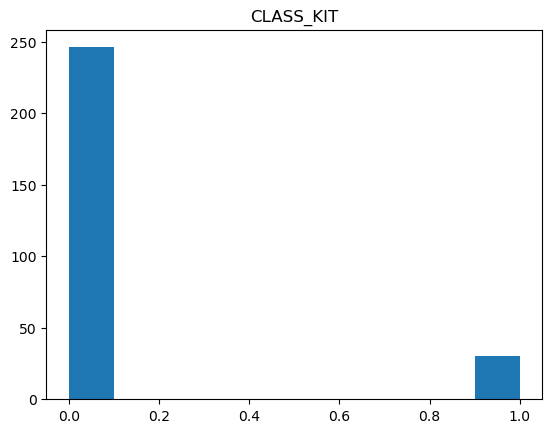

In [14]:
plt.hist(ys[:, 0])
num_class1 = list(ys[:, 0] == 1.0).count(True)
print(f"There is only {num_class1} binders.")
plt.title(target_order[0])

num_class0 = list(ys[:, 0] == 0.0).count(True)
num_missing = num_class0 - num_class1
print(f"There's {num_missing} class 1 datapoints missing.")

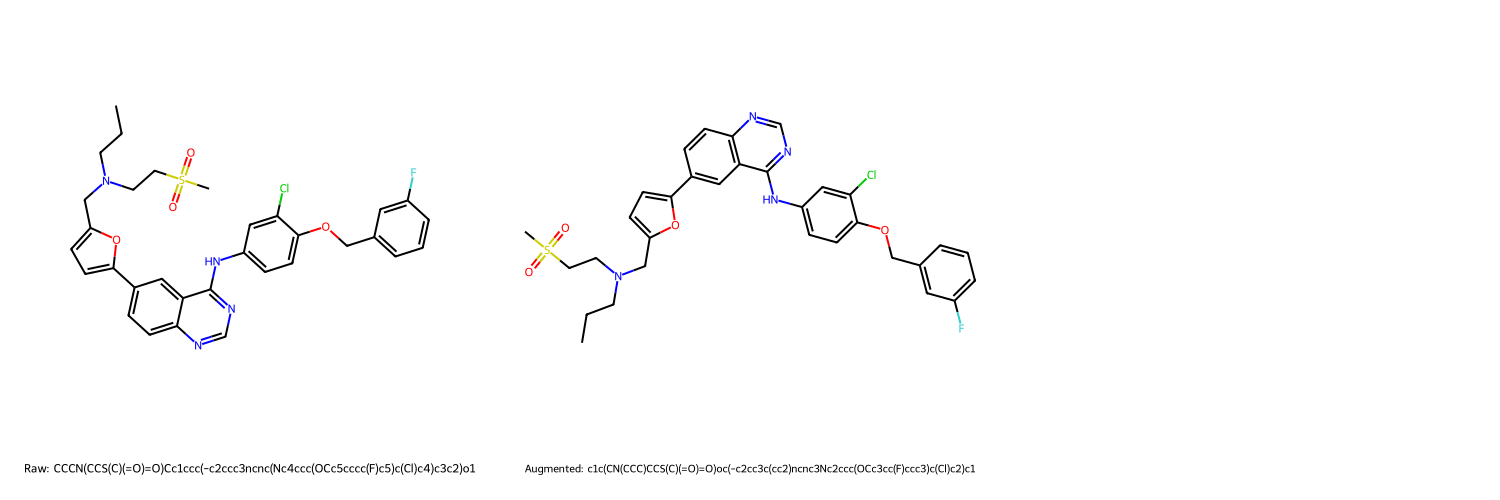

In [19]:
## Balancing SMILES-based dataset

import random
from rdkit.Chem import Draw

mapping = {
 (0.0, 0.0, 0.0): 0,
 (1.0, 0.0, 0.0): 1,
 (1.0, 0.0, 1.0): 2,
 (1.0, 1.0, 0.0): 3,
 (1.0, 1.0, 1.0): 4,
}
inv_mapping = {v: k for k, v in mapping.items()}

counts = []
for target in [2, 1, 0]: #[0]:
    num_target_binders = len([(x_,y_) for x_, y_ in zip(X, ys) if y_[target] == 1.0])
    num_target_nonbinders = len([(x_,y_) for x_, y_ in zip(X, ys) if y_[target] == 0.0])
    
    num_missing = num_target_nonbinders - num_target_binders
    class_samples = [(x_,y_) for x_, y_ in zip(X, ys) if y_[target] == 1.0]

    #num_missing = num_target_binders - num_target_nonbinders
    #class_samples = [(x_,y_) for x_, y_ in zip(X, ys) if y_[target] == 0.0]
    
    sme = SmilesEnumerator()
    for _ in range(num_missing):
        sample = random.sample(class_samples, k=1)
        randomized_x = sme.randomize_smiles(sample[0][0])
        X = np.append(X, randomized_x)
        ys = np.append(ys, [sample[0][1]])
    ys = ys.reshape(-1, 3)
mols = [Chem.MolFromSmiles(sample[0][0]), Chem.MolFromSmiles(randomized_x)]
Draw.MolsToGridImage(mols, subImgSize=(500, 500), legends=[f"Raw: {sample[0][0]}", f"Augmented: {randomized_x}"])

There is now 558 binders and 558 non-binders.


Text(0.5, 1.0, 'CLASS_KIT')

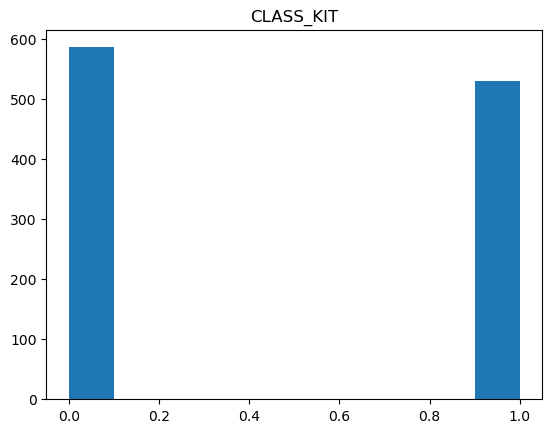

In [22]:
plt.hist(ys[:, 2])
num_binders = list(ys[:, 0] == 1.0).count(True)
num_nonbinders = list(ys[:, 0] == 0.0).count(True)
print(f"There is now {num_binders} binders and {num_nonbinders} non-binders.")
plt.title(target_order[0])

## Tokenizing SMILES

In [23]:
import os

from deepchem.feat.smiles_tokenizer import SmilesTokenizer
import torch

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ubuntu/micromamba/envs/moml-mark/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [24]:
tokenizer = SmilesTokenizer('vocab.txt')

In [25]:
tokenized_X = [tokenizer.encode(smiles, padding="max_length", max_length=84) for smiles in X]
tokenized_X = np.array(tokenized_X)

In [26]:
tokenized_X

array([[12, 19, 22, ...,  0,  0,  0],
       [12, 16, 16, ...,  0,  0,  0],
       [12, 16, 23, ...,  0,  0,  0],
       ...,
       [12, 15, 20, ...,  0,  0,  0],
       [12, 28, 15, ...,  0,  0,  0],
       [12, 15, 20, ...,  0,  0,  0]])

## Prep the data for the model

In [28]:
training_samples = []
for target in [0, 1, 2]:
    training_samples.extend([(ligand, target, y_) for ligand, y_ in zip(tokenized_X, ys[:, target])])

In [29]:
ligands = np.array([sample[0] for sample in training_samples])
targets = np.array([sample[1] for sample in training_samples])
labels = np.array([sample[2] for sample in training_samples])

ligands = torch.from_numpy(ligands)
targets = torch.from_numpy(targets)
targets = targets.reshape(-1, 1)
labels = torch.from_numpy(labels.astype(dtype=np.float32))

## PyTorch model

In [30]:
"""
import torch
import torch.nn as nn
import torch.optim as optim

# Define the SMILES neural network
class SMILESNeuralNet(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SMILESNeuralNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, ligand, target):
        # ligand embedding
        embedded = self.embedding(x)
        embedded = embedded.mean(dim=1)  # Do we need averaging of embeddings?

        # target embedding
        
        out = self.fc1(embedded)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out) # binarize the output
        return out
"""

'\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\n\n# Define the SMILES neural network\nclass SMILESNeuralNet(nn.Module):\n    \n    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):\n        super(SMILESNeuralNet, self).__init__()\n        self.embedding = nn.Embedding(vocab_size, embed_dim)\n        self.fc1 = nn.Linear(embed_dim, hidden_dim)\n        self.relu = nn.ReLU()\n        self.fc2 = nn.Linear(hidden_dim, output_dim)\n        self.sigmoid = nn.Sigmoid()\n        \n    def forward(self, ligand, target):\n        # ligand embedding\n        embedded = self.embedding(x)\n        embedded = embedded.mean(dim=1)  # Do we need averaging of embeddings?\n\n        # target embedding\n        \n        out = self.fc1(embedded)\n        out = self.relu(out)\n        out = self.fc2(out)\n        out = self.sigmoid(out) # binarize the output\n        return out\n'

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim

# TODO: can make this way more modular by factoring out the common part (and then just instantiate two versions for ligand & target)

class Sin(nn.Module):
    def forward(self, x_inp):
        return torch.sin(x_inp)
        
# Define the SMILES neural network
class SMILESNeuralNet(nn.Module):
    
    def __init__(self, ligand_vocab_size, ligand_embed_dim, target_embed_dim, ligand_hidden_dim, target_hidden_dim, output_dim):
        super(SMILESNeuralNet, self).__init__()

        # ligand "track"
        self.ligand_embedding = nn.Embedding(num_embeddings=ligand_vocab_size, embedding_dim=ligand_embed_dim)    
        #self.ligand_fc1 = nn.Sequential(*[nn.Linear(ligand_embed_dim, ligand_hidden_dim)]*2)
        self.ligand_fc1 = nn.Linear(ligand_embed_dim, ligand_hidden_dim)
        self.ligand_sin = Sin()
        
        # target "track"
        self.target_embedding = nn.Embedding(num_embeddings=3, embedding_dim=target_embed_dim)
        #self.target_fc1 = nn.Sequential(*[nn.Linear(target_embed_dim, target_hidden_dim)]*2)
        self.target_fc1 = nn.Linear(target_embed_dim, target_hidden_dim)
        self.target_sin = Sin()

        self.fc2 = nn.Linear(ligand_hidden_dim + target_hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, ligand, target):
        
        # ligand "track"
        embedded_ligand = self.ligand_embedding(ligand)
        embedded_ligand = embedded_ligand.mean(dim=1)  # Do we need averaging of embeddings?
        ligand_out = self.ligand_fc1(embedded_ligand)
        ligand_out = self.ligand_sin(ligand_out)
        
        # target "track"
        embedded_target = self.target_embedding(target)
        embedded_target = embedded_target.mean(dim=1)  # Do we need averaging of embeddings?
        target_out = self.target_fc1(embedded_target)
        target_out = self.target_sin(target_out)

        # concatenate
        concat_out = torch.cat((ligand_out, target_out), 1)
        
        out = self.fc2(concat_out)
        out = self.sigmoid(out) # binarize the output
        return out

## Hyperparameter tuning

In [85]:
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def objective(trial):
    # Hyperparameters to tune
    ligand_embed_dim = trial.suggest_categorical('ligand_embed_dim', [16, 32, 64, 128])
    target_embed_dim = trial.suggest_categorical('target_embed_dim', [8, 16, 32, 64])
    ligand_hidden_dim = trial.suggest_categorical('ligand_hidden_dim', [32, 128, 256])
    target_hidden_dim = trial.suggest_categorical('target_hidden_dim', [16, 32, 128, 256])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 1000, 5000)
    
    # KFold Cross-Validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in kfold.split(ligands):
        train_ligands, val_ligands = ligands[train_idx], ligands[val_idx]
        train_targets, val_targets = targets[train_idx], targets[val_idx]
        train_y, val_y = labels[train_idx], labels[val_idx]
        
        # Initialize the model
        model = SMILESNeuralNet(vocab_size=tokenizer.vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim, output_dim=1)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Training loop
        dataset = torch.utils.data.TensorDataset(train_X, train_y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        model.train()
        for epoch in range(epochs):
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y.float())
                loss.backward()
                optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_X)
            val_predictions = (val_outputs.squeeze().numpy() > 0.5).astype(int)
        
        accuracy = accuracy_score(val_y.numpy(), val_predictions)
        accuracies.append(accuracy)
    
    # Return the mean accuracy across folds
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best parameters and best score
print("Best parameters found: ", study.best_params)
print("Best accuracy found: ", study.best_value)

[I 2024-06-21 15:38:30,416] A new study created in memory with name: no-name-dc73b789-351a-49b7-adc8-b50abd67cc09
[I 2024-06-21 15:40:16,465] Trial 0 finished with value: 0.9085365853658537 and parameters: {'embed_dim': 256, 'hidden_dim': 256, 'lr': 0.0025435256326853052, 'batch_size': 32, 'epochs': 1780}. Best is trial 0 with value: 0.9085365853658537.
[I 2024-06-21 15:41:28,794] Trial 1 finished with value: 0.8963414634146342 and parameters: {'embed_dim': 256, 'hidden_dim': 128, 'lr': 0.0006613260049188675, 'batch_size': 64, 'epochs': 1760}. Best is trial 0 with value: 0.9085365853658537.
[I 2024-06-21 15:46:32,610] Trial 2 finished with value: 0.8800813008130081 and parameters: {'embed_dim': 256, 'hidden_dim': 16, 'lr': 0.0012538202201686128, 'batch_size': 16, 'epochs': 3795}. Best is trial 0 with value: 0.9085365853658537.
[I 2024-06-21 15:51:02,524] Trial 3 finished with value: 0.894308943089431 and parameters: {'embed_dim': 32, 'hidden_dim': 128, 'lr': 0.00030567338423666317, 'ba

Best parameters found:  {'embed_dim': 256, 'hidden_dim': 256, 'lr': 0.0025435256326853052, 'batch_size': 32, 'epochs': 1780}
Best accuracy found:  0.9085365853658537


In [55]:
targets.shape

torch.Size([3348, 1])

In [78]:
# Retraining a model with all training value using the best hyperparameters

# Best hyperparameters
ligand_vocab_size = tokenizer.vocab_size
#ligand_embed_dim = study.best_params["ligand_embed_dim"]
#target_embed_dim = study.best_params["target_embed_dim"]
#ligand_hidden_dim = study.best_params["ligand_hidden_dim"]
#target_hidden_dim = study.best_params["target_hidden_dim"]
#num_epochs = study.best_params["epochs"]

ligand_embed_dim = 32
target_embed_dim = 8
ligand_hidden_dim = 64
target_hidden_dim = 16
num_epochs = 1000

output_dim = 1  # For now we only want binary classification

# Instantiate the model, loss function, and optimizer
model = SMILESNeuralNet(ligand_vocab_size, ligand_embed_dim, target_embed_dim, ligand_hidden_dim, target_hidden_dim, output_dim)
criterion = nn.BCELoss()  # Using BCELoss since we're doing binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

if isinstance(ligands, np.ndarray):
    ligands = torch.from_numpy(ligands)
    targets = torch.from_numpy(targets)
    targets = targets.reshape(-1, 1)
    labels = torch.from_numpy(labels.astype(dtype=np.float32))

# Training loop
loss_over_time = []
for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(ligands, targets)
    loss = criterion(outputs.squeeze(), labels)
    loss_over_time.append(loss)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

Epoch [10/1000], Loss: 0.6835
Epoch [20/1000], Loss: 0.6693
Epoch [30/1000], Loss: 0.6572
Epoch [40/1000], Loss: 0.6456
Epoch [50/1000], Loss: 0.6332
Epoch [60/1000], Loss: 0.6190
Epoch [70/1000], Loss: 0.6024
Epoch [80/1000], Loss: 0.5829
Epoch [90/1000], Loss: 0.5608
Epoch [100/1000], Loss: 0.5369
Epoch [110/1000], Loss: 0.5123
Epoch [120/1000], Loss: 0.4887
Epoch [130/1000], Loss: 0.4672
Epoch [140/1000], Loss: 0.4480
Epoch [150/1000], Loss: 0.4310
Epoch [160/1000], Loss: 0.4157
Epoch [170/1000], Loss: 0.4017
Epoch [180/1000], Loss: 0.3888
Epoch [190/1000], Loss: 0.3768
Epoch [200/1000], Loss: 0.3654
Epoch [210/1000], Loss: 0.3546
Epoch [220/1000], Loss: 0.3445
Epoch [230/1000], Loss: 0.3348
Epoch [240/1000], Loss: 0.3257
Epoch [250/1000], Loss: 0.3169
Epoch [260/1000], Loss: 0.3086
Epoch [270/1000], Loss: 0.3007
Epoch [280/1000], Loss: 0.2932
Epoch [290/1000], Loss: 0.2862
Epoch [300/1000], Loss: 0.2795
Epoch [310/1000], Loss: 0.2732
Epoch [320/1000], Loss: 0.2673
Epoch [330/1000],

Text(0, 0.5, 'Loss')

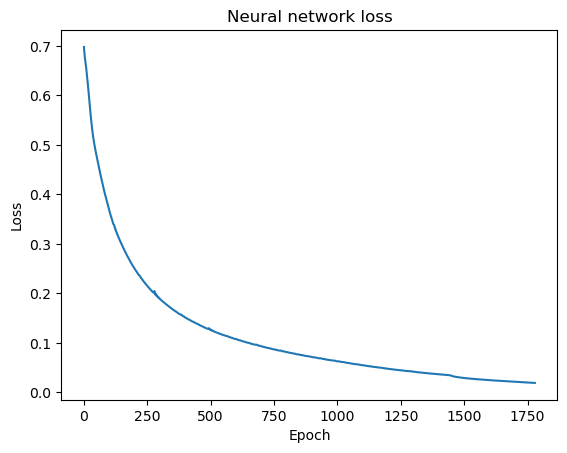

In [87]:
plt.plot(list(range(num_epochs)), [l.detach().numpy() for l in loss_over_time])
plt.title("Neural network loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [88]:
model.eval()  # set to evaluation mode for inference time

tokenized_test_X = [tokenizer.encode(smiles, padding="max_length", max_length=84) for smiles in test.X]
tokenized_test_X = np.array(tokenized_test_X)
tokenized_test_X = torch.from_numpy(tokenized_test_X)  # to tensor

# Perform inference
with torch.no_grad():  # turn off gradient calculation
    predictions = model(tokenized_test_X)
    predictions = predictions.squeeze().numpy()  # convert to numpy
    
print("Predictions:", predictions)

Predictions: [7.66557719e-07 6.47950768e-01 2.53300514e-09 3.55505847e-07
 1.36573392e-04 4.05147177e-04 4.26363433e-03 1.52565451e-06
 1.91057131e-01 3.75298750e-14 1.23952107e-12 2.41079934e-09
 2.39237677e-02 2.92113036e-05 1.25974405e-03 2.55905790e-03
 8.16435039e-01 2.09688656e-02 5.54522899e-08 2.70365653e-13
 1.49123334e-05 5.59252294e-05 2.83529866e-10 9.99969363e-01
 1.64446283e-05 3.47000395e-07 1.50904269e-03 6.11918949e-07
 1.30685493e-01 7.39908117e-08 9.40136135e-01 1.77515114e-10
 9.99993920e-01 1.48617360e-03 3.90427373e-02 7.79655762e-04
 9.53931212e-01 8.26552332e-06 1.25742494e-03 1.69531740e-02
 1.10849127e-01 2.42466733e-01 5.36452159e-02 2.51122412e-08
 6.43824576e-04 4.75486189e-07 3.49696353e-03 2.80395313e-03
 1.39730843e-02 1.64882913e-02 6.50351405e-01 5.37519229e-09
 3.67910070e-05 3.05379260e-08 1.22520015e-01 2.05534270e-05
 5.39630689e-02 1.92120731e-01 9.99774873e-01 6.18554592e-01
 1.68181535e-09 2.30652653e-02 4.99985217e-05 9.93047259e-04
 4.24763493

In [89]:
# binarize the predictions
predicted_labels = (predictions > 0.5).astype(np.float32)

In [90]:
y_prob = {"CLASS_KIT": predictions, 'CLASS_KIT_(T6701_mutant)': predictions, 'CLASS_KIT_(V560G_mutant)': predictions}
y_pred = {"CLASS_KIT": predicted_labels, 'CLASS_KIT_(T6701_mutant)': predicted_labels, 'CLASS_KIT_(V560G_mutant)': predicted_labels}

results = benchmark.evaluate(y_pred=y_pred, y_prob=y_prob)

In [91]:
results

{
  "name": null,
  "description": "",
  "tags": [],
  "user_attributes": {},
  "owner": null,
  "polaris_version": "dev",
  "benchmark_name": "pkis1-kit-wt-mut-c-1",
  "benchmark_owner": {
    "slug": "polaris",
    "external_id": "org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu",
    "type": "organization"
  },
  "github_url": null,
  "paper_url": null,
  "contributors": null,
  "artifact_id": null,
  "benchmark_artifact_id": "polaris/pkis1-kit-wt-mut-c-1",
  "results": [
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "accuracy",
      "Score": 0.7701149425
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "accuracy",
      "Score": 0.8390804598
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "accuracy",
      "Score": 0.7126436782
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "f1",
      "Score": 0.1666666667
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "f1",
      "Score": 0.3636363636
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "f1",
      "Score": 0.4186046512
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "roc_auc",
      "Score": 0.6487279843
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "roc_auc",
      "Score": 0.7833333333
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "roc_auc",
      "Score": 0.7704826038
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "pr_auc",
      "Score": 0.3357154518
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "pr_auc",
      "Score": 0.4916691438
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "pr_auc",
      "Score": 0.7263792578
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "mcc",
      "Score": 0.0383272895
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "mcc",
      "Score": 0.2738849887
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "mcc",
      "Score": 0.3867220984
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "cohen_kappa",
      "Score": 0.0376106195
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "cohen_kappa",
      "Score": 0.2724014337
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "cohen_kappa",
      "Score": 0.29406037
    }
  ]
}

## Outstanding TODOs

- Perform joint embedding with the target
- Hyperparameter tuning